# [Distilling the Knowledge in a Neural Network](https://arxiv.org/pdf/1503.02531)

## Intro

* Training stage and deployment stage have different requirements so should use different models
    * Training stage model should be good at extracting structure from data
    * Deployed model should be efficient and computionally affordable. <br><br>
* If a complex model generalizes well then a small model trained to generalize in the same way as the complex model will usually do better on test data than training the small model directly on the same data that was used to train the complex model
  * One reason is even the incorrect classes' probabilities in multi-class classification provide knowledge; such as which classes are relatively more similar <br><br>
* Logits in small model can be trained to match the logits in the complex model using MSE.
    * Another route is to raise temperature (entropy) of complex model's softmax and use same temperature for small model's softmax while training to match the complex model's probabilities.
    * Reason for not training using probabilities with no temperature is that probabilities of incorrect answers are often too close to zero. <br><br>
* The small model can be trained entirely on unlabeled data or original training set.
    * If training on original training set, can use cost function that balances the hard target of data and soft targets of the complex model.
    * Soft targets derived from training on full training set allow a student model to generalize well from only 3% of training set or even missing class targets (as long as we correct the bias term for the class)

## Temperature

* Temperature is a parameter that decides how soft the distribution will be. Raising the temperature raises the entropy (softness).
* Softmax by default uses temperature $T=1$.
\begin{align}
q_i = \frac{exp(z_i / T)}{\sum_j{exp(z_j / T)}}
\end{align}

In [1]:
import torch

def softmax_with_temperature(logits, temperature): 
    num = torch.exp(logits / temperature)
    den = torch.exp(logits / temperature).sum()
    return num / den

In [2]:
x = torch.tensor([10.0, 1.0, 3.0, -5.0])
torch.nn.functional.softmax(x, dim=-1) # Default softmax

tensor([9.9897e-01, 1.2328e-04, 9.1094e-04, 3.0559e-07])

In [3]:
softmax_with_temperature(x, 1) # Temperature=1 -> Default softmax

tensor([9.9897e-01, 1.2328e-04, 9.1094e-04, 3.0559e-07])

In [4]:
softmax_with_temperature(x, 10) # Temperature=10 -> More balanced

tensor([0.4703, 0.1912, 0.2335, 0.1049])

In [5]:
softmax_with_temperature(x, 1e10) # Extremely high temperature -> Max entropy (uniform distribution)

tensor([0.2500, 0.2500, 0.2500, 0.2500])

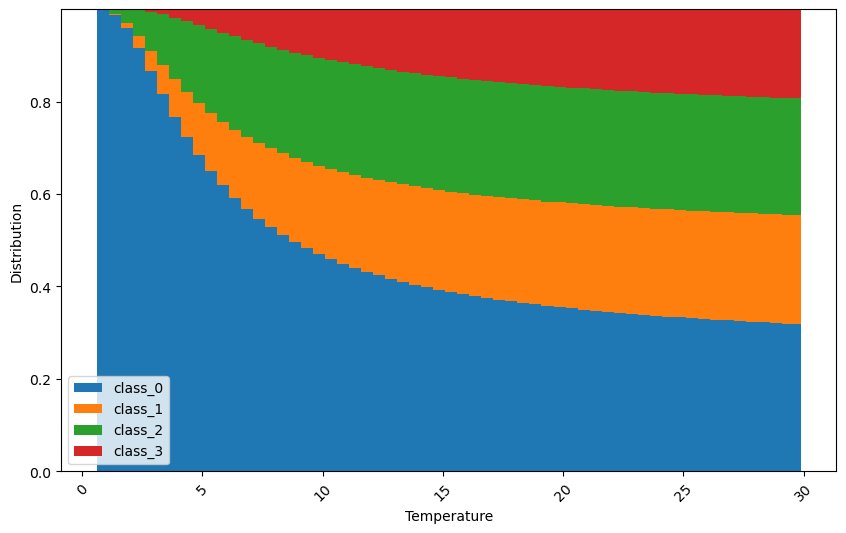

In [6]:
# Plot showing temperature's affect on distribution
import matplotlib.pyplot as plt 
import numpy as np

Ts = torch.arange(1, 30, 0.5)
dists = torch.zeros(len(Ts), len(x))
for i, T in enumerate(Ts):
    dists[i] = softmax_with_temperature(x, T)

plt.figure(figsize=(10, 6))
for i in range(len(x)):
    if i == 0:
        plt.bar(Ts, dists[:,i], label=f"class_{i}")
    else:
        plt.bar(Ts, dists[:,i], label=f"class_{i}", bottom=dists[:, :i].sum(axis=1))

plt.xlabel('Temperature')
plt.ylabel('Distribution')
plt.legend()
plt.xticks(rotation=45)
plt.show()

\begin{align}
\frac{\partial{}q_i}{\partial{}z_i} = \frac{q_i(1-q_i)}{T}
\end{align}
\begin{align}
\frac{\partial{}q_i}{\partial{}z_k} = \frac{-q_iq_k}{T}
\end{align}

## Training

In [7]:
from torch import nn
import torch.nn.functional as F

# Large (complex) model with dropout
class LargeNet(nn.Module):
    def __init__(self, input_size=(28,28), output_size=10, num_neurons=1200, p=0.5):
        super(LargeNet, self).__init__()
        self.p = p
        input_size = np.prod(input_size)
        self.fc1 = nn.Linear(input_size, num_neurons)
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.out = nn.Linear(num_neurons, output_size)

    def forward(self, x):
        fc1 = F.relu(self.fc1(x))
        fc1 = F.dropout(fc1, p=self.p)
        fc2 = F.relu(self.fc2(fc1))
        fc2 = F.dropout(fc2, p=self.p)
        logits = self.out(fc2)
        return logits

# Small (distilled) model without dropout
class SmallNet(nn.Module):
    def __init__(self, input_size=(28,28), output_size=10, num_neurons=800):
        super(SmallNet, self).__init__()
        input_size = np.prod(input_size)
        self.fc1 = nn.Linear(input_size, num_neurons)
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.out = nn.Linear(num_neurons, output_size)

    def forward(self, x):
        fc1 = F.relu(self.fc1(x))
        fc2 = F.relu(self.fc2(fc1))
        logits = self.out(fc2)
        return logits

In [13]:
# Data
from torchvision import datasets, transforms

# Jitter
jitter_range = 2
image_size = 28
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=0, translate=(2/28, 2/28)),
])

# Loading MNIST data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create data loaders
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomAffine(degrees=[0.0, 0.0], translate=(0.07142857142857142, 0.07142857142857142))
           )

In [14]:
from tqdm.notebook import tqdm

def train_model(model, optimizer, num_epochs=20):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
    
        progress_bar = tqdm(total=len(train_loader))
    
        for inputs, labels in train_loader:
            inputs, labels = inputs.view(inputs.shape[0], -1).to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights
            
            running_loss += loss.item() * inputs.size(0)
            
            progress_bar.update(1)
            progress_bar.set_description(f"Loss: {loss.item():.4f}")
        all_preds, all_labels = test_model(model)
        num_instances = len(all_preds)
        correct = (all_preds == all_labels).sum()
        accuracy =  correct / num_instances
        errors = num_instances - correct
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy}, Errors: {errors}")

def test_model(model):
    model.eval()
    progress_bar = tqdm(total=len(test_loader))
    
    all_preds, all_labels = [], []
    for inputs, labels in test_loader:
        inputs, labels = inputs.view(inputs.shape[0], -1).to(device), labels.to(device)
        
        outputs = model(inputs)  # Forward pass
        preds = outputs.argmax(axis=-1)
        all_preds += preds
        all_labels += labels
        progress_bar.update(1)
    all_preds, all_labels = torch.tensor(all_preds), torch.tensor(all_labels)
    return all_preds, all_labels

In [15]:
from torch import optim
LR = 1e-5
large_model = LargeNet()
optimizer = optim.Adam(large_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
train_model(large_model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8933, Accuracy: 0.6420000195503235, Errors: 3580


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.1012, Accuracy: 0.7103000283241272, Errors: 2897


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.8953, Accuracy: 0.7534999847412109, Errors: 2465


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.7894, Accuracy: 0.7778000235557556, Errors: 2222


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7196, Accuracy: 0.8029000163078308, Errors: 1971


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.6566, Accuracy: 0.8197000026702881, Errors: 1803


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.6084, Accuracy: 0.8359000086784363, Errors: 1641


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.5583, Accuracy: 0.8421000242233276, Errors: 1579


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.5254, Accuracy: 0.8611999750137329, Errors: 1388


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.4869, Accuracy: 0.8673999905586243, Errors: 1326


In [17]:
large_preds, large_labels = test_model(large_model)

  0%|          | 0/157 [00:00<?, ?it/s]

In [18]:
(large_preds != large_labels).sum()

tensor(1340)

In [19]:
(large_preds == large_labels).sum() / len(large_preds)

tensor(0.8660)

In [20]:
LR = 1e-5
small_model = SmallNet()
optimizer = optim.Adam(small_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [21]:
train_model(small_model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.7100, Accuracy: 0.70660001039505, Errors: 2934


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.9291, Accuracy: 0.7741000056266785, Errors: 2259


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.7614, Accuracy: 0.8019000291824341, Errors: 1981


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.6622, Accuracy: 0.8274999856948853, Errors: 1725


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.6096, Accuracy: 0.8411999940872192, Errors: 1588


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.5547, Accuracy: 0.8536999821662903, Errors: 1463


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [33]:
small_preds, small_labels = test_model(small_model)

  0%|          | 0/40 [00:00<?, ?it/s]

In [39]:
(small_preds != small_labels).sum()

tensor(191)

In [36]:
(small_preds == small_labels).sum() / len(small_preds)

tensor(0.9809)